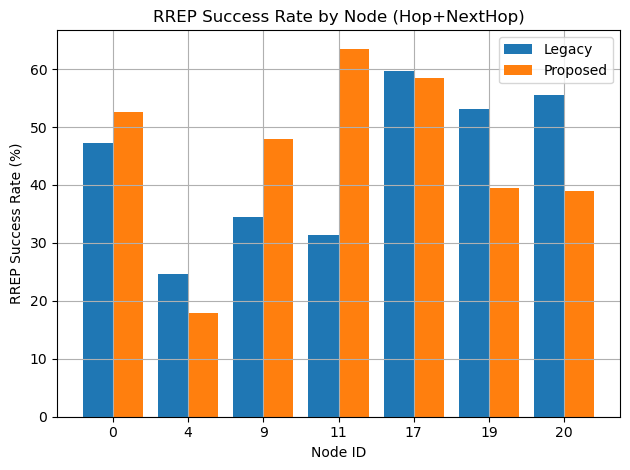

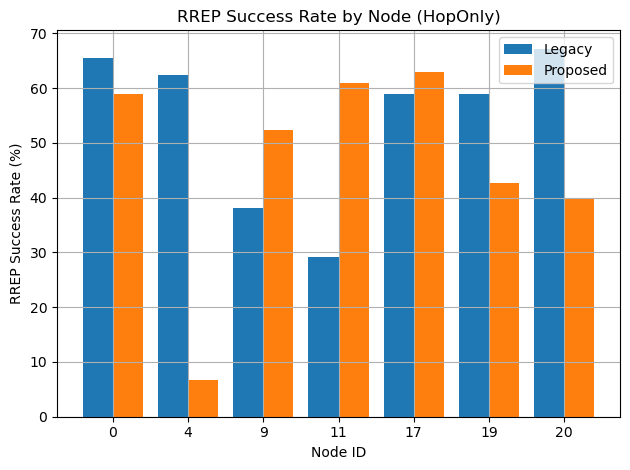

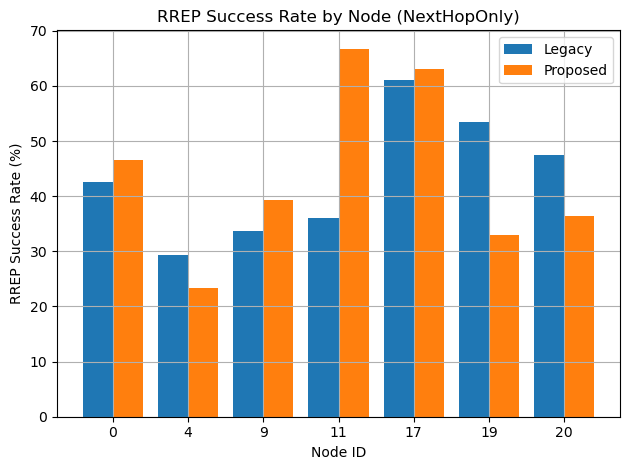

In [1]:
import os
import bisect
import pandas as pd
import matplotlib.pyplot as plt

nodes = [0, 4, 6, 7, 9, 10, 11, 17, 19, 20]
xnodes = [6, 7, 17, 18, 21, 22, 24, 26, 27, 29]

change_types = ["Hop+NextHop", "HopOnly", "NextHopOnly"]
interval = 3.0

base_path = "C:/Users/Choe JongHyeon/Desktop/Applied Science/시뮬레이션 결과/Lifetime 결과_V02/고밀도/고속/"

def load_and_classify_routing_log(path):
    df = pd.read_csv(path)
    df.columns = [
        "Time", "Node", "Destination", "Previous_LifeTime", "New_LifeTime",
        "Previous_NextHop", "New_NextHop", "Previous_HopCount", "New_HopCount"
    ]
    df["HopChange"] = df["Previous_HopCount"] != df["New_HopCount"]
    df["NextHopChange"] = df["Previous_NextHop"] != df["New_NextHop"]
    df["LifeTimeChange"] = df["Previous_LifeTime"] != df["New_LifeTime"]
    df["ChangeType"] = df.apply(
        lambda row: "Hop+NextHop" if row["HopChange"] and row["NextHopChange"]
        else "HopOnly" if row["HopChange"]
        else "NextHopOnly" if row["NextHopChange"]
        else "LifeTimeOnly" if row["LifeTimeChange"]
        else "NoChange",
        axis=1
    )
    return df

def estimate_rrep_success_rate(routing_log_path, recovery_log_path, change_type, interval):
    if not os.path.exists(routing_log_path) or not os.path.exists(recovery_log_path):
        return None

    df = load_and_classify_routing_log(routing_log_path)
    df = df[df["ChangeType"] == change_type][["Time", "Destination"]].copy()
    df["Destination"] = df["Destination"].astype(str)

    if df.empty:
        return 0.0

    recovery_df = pd.read_csv(recovery_log_path, header=None, names=["Time", "Node", "Destination", "Event"])
    rrep_df = recovery_df[recovery_df["Event"] == "RREP_RECV"][["Time", "Destination"]].copy()
    rrep_df["Destination"] = rrep_df["Destination"].astype(str)

    rrep_dict = {}
    for dest, group in rrep_df.groupby("Destination"):
        rrep_dict[dest] = sorted(group["Time"].tolist())

    total = len(df)
    success = 0

    for _, row in df.iterrows():
        t = row["Time"]
        d = row["Destination"]
        if d not in rrep_dict:
            continue
        times = rrep_dict[d]
        idx = bisect.bisect_left(times, t)
        if idx < len(times) and times[idx] <= t + interval:
            success += 1

    return (success / total) * 100 if total > 0 else 0.0

results = {change: [] for change in change_types}
valid_nodes = []

for node_id in nodes:
    legacy_routing = os.path.join(base_path, "기존", str(node_id), "aodv_routing_log.csv")
    legacy_recovery = os.path.join(base_path, "기존", str(node_id), "recovery_log.csv")
    proposed_routing = os.path.join(base_path, "제안", str(node_id), "aodv_routing_log.csv")
    proposed_recovery = os.path.join(base_path, "제안", str(node_id), "recovery_log.csv")

    if not all(map(os.path.exists, [legacy_routing, legacy_recovery, proposed_routing, proposed_recovery])):
        continue

    valid_nodes.append(node_id)

    for change in change_types:
        legacy_rate = estimate_rrep_success_rate(legacy_routing, legacy_recovery, change, interval)
        proposed_rate = estimate_rrep_success_rate(proposed_routing, proposed_recovery, change, interval)
        results[change].append((legacy_rate, proposed_rate))

for change in change_types:
    if change not in results or not results[change]:
        continue

    legacy_rates, proposed_rates = zip(*results[change])
    x = range(len(valid_nodes))
    plt.figure()
    plt.bar([i - 0.2 for i in x], legacy_rates, width=0.4, label="Legacy")
    plt.bar([i + 0.2 for i in x], proposed_rates, width=0.4, label="Proposed")
    plt.xticks(x, [str(n) for n in valid_nodes])
    plt.xlabel("Node ID")
    plt.ylabel("RREP Success Rate (%)")
    plt.title(f"RREP Success Rate by Node ({change})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
